In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import zipfile

# zip_filename= '/content/drive/Shareddrives/UD1/Study/Image Processing/11000.zip'
# directory_to_extract_to = '/content/drive/Shareddrives/UD1/Study/Image Processing'
# with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

In [ ]:
# src_path = '/content/drive/Shareddrives/UD1/Study/Image Processing/11000'
# dest_path = '/content/drive/Shareddrives/UD1/Study/Image Processing/data'

# for i in os.listdir(src_path):
#     os.rename(os.path.join(src_path,i), os.path.join(dest_path,i))

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications.resnet import ResNet101, ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
import random
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, shuffle
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report

from tqdm import tqdm
from google.colab.patches import cv2_imshow
%matplotlib inline

In [ ]:
all_data = pd.read_csv('/content/drive/Shareddrives/UD1/Study/Image Processing/mask-data.csv')    # reading the csv file
all_data.head()   

,filename,label
0,00000_Mask.jpg,correctly_masked
1,00001_Mask.jpg,correctly_masked
2,00002_Mask.jpg,correctly_masked
3,00003_Mask.jpg,correctly_masked
4,00004_Mask.jpg,correctly_masked


In [ ]:
train, testval = train_test_split(all_data, test_size=0.2, random_state=22)
val, test = train_test_split(testval, test_size=0.5, random_state=23)

In [ ]:
print(train.size,val.size,test.size)

6128 766 766


In [ ]:
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

In [ ]:
onehotencoder = OneHotEncoder()
trainY = np.array(train.label.tolist())
trainY = onehotencoder.fit_transform(trainY.reshape(-1, 1)).toarray()

valY = np.array(val.label.tolist())
valY = onehotencoder.fit_transform(valY.reshape(-1, 1)).toarray()

testY = np.array(test.label.tolist())
testY = onehotencoder.fit_transform(testY.reshape(-1, 1)).toarray()

In [ ]:
def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img

def channel_shift(img, value):
    value = int(random.uniform(-value, value))
    img = img + value
    img[:,:,:][img[:,:,:]>255]  = 255
    img[:,:,:][img[:,:,:]<0]  = 0
    img = img.astype(np.uint8)
    return img

def zoom_img(img, value):
    if value > 1 or value < 0:
        print('Value for zoom should be less than 1 and greater than 0')
        return img
    value = random.uniform(value, 1)
    h, w = img.shape[:2]
    h_taken = int(value*h)
    w_taken = int(value*w)
    h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)
    img = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    img = fill(img, h, w)
    return img

def horizontal_flip(img, flag):
    if flag:
        return cv2.flip(img, 1)
    else:
        return img

def random_rotate(img, min_angle, max_angle):
    rotation_angle = random.uniform(min_angle, max_angle)
    rotated_img = ImageDataGenerator().apply_transform(x=img, transform_parameters={'theta': rotation_angle}) 
    return rotated_img

def horizontal_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
    img = fill(img, h, w)
    return img

def brightness_augment(img, factor=0.5): 
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) #convert to hsv
    hsv = np.array(hsv, dtype=np.float64)
    hsv[:, :, 2] = hsv[:, :, 2] * (factor + np.random.uniform()) #scale channel V uniformly
    hsv[:, :, 2][hsv[:, :, 2] > 255] = 255 #reset out of range values
    rgb = cv2.cvtColor(np.array(hsv, dtype=np.uint8), cv2.COLOR_HSV2RGB)
    return rgb

In [ ]:
def generator(data, Y, batch_size = 32, shift = False, flip = False, channel = False, zoom = False, brightness = False, rotation = False):
    while True:
        for start in range(0, len(data), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(data))
            for i in range(start, end):
                img = cv2.imread("/content/drive/Shareddrives/UD1/Study/Image Processing/data/" + data['filename'][i])
                img = cv2.resize(img, (224, 224))
                x_batch.append(img)
                y_batch.append(Y[i])
                if shift:
                    shift_img = horizontal_shift(img, 0.7)
                    x_batch.append(img)
                    y_batch.append(Y[i])
                if flip:
                    flip_img = horizontal_flip(img, True)
                    x_batch.append(flip_img)
                    y_batch.append(Y[i])
                if shift:
                    channel_img = channel_shift(img, 60)
                    x_batch.append(channel_img)
                    y_batch.append(Y[i])
                if zoom:
                    zoom_image = zoom_img(img, 0.8)
                    x_batch.append(zoom_image)
                    y_batch.append(Y[i])
                if brightness:
                    brightness_intensity = random.uniform(0.3, 7.0)
                    brightness_img = ImageDataGenerator().apply_transform(x=img, transform_parameters={'brightness': brightness_intensity})
                    x_batch.append(brightness_img)
                    y_batch.append(Y[i])
                if rotation:
                    rotated_img = random_rotate(img, -90.0, 90.0)
                    x_batch.append(rotated_img)
                    y_batch.append(Y[i])
            x_batch, y_batch = shuffle(x_batch, y_batch)
            yield np.array(x_batch),np.array(y_batch)

In [ ]:
train_label_list = train["label"].tolist()

In [ ]:
np.unique(train_label_list)

array(['correctly_masked', 'incorrectly_masked'], dtype='<U18')

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_label_list),
                                                 train_label_list)
class_weights

calculated_weights = {
    0: class_weights[0],
    1: class_weights[1],
}
calculated_weights

{0: 0.9986962190352021, 1: 1.0013071895424837}

In [ ]:
INPUT_SHAPE = (224, 224, 3)
INIT_LR = 1e-4
EPOCHS = 20
BATCH_SIZE = 32

In [ ]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE,
    )

base_model.trainable = False

inputs = keras.Input(shape=INPUT_SHAPE)

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
outputs = Dense(2, activation='softmax')(x)
model = Model(inputs, outputs)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=100000,
    decay_rate=0.94,
    staircase=True,
)

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()]
    )

model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               163968    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 258       
Total params: 2,422,210
Trainable params: 164,226
Non-trainable params: 2,257,984
_____________________________________

In [ ]:
hist = model.fit(
    x=generator(train, trainY, BATCH_SIZE, shift=False, flip=True, channel=False, zoom=False, brightness=False, rotation=True),
    epochs=EPOCHS,
    steps_per_epoch=len(train)//BATCH_SIZE,
    class_weight= calculated_weights,
    validation_data=generator(val, valY, BATCH_SIZE),
    validation_steps=len(val)//BATCH_SIZE,
    ).history

Epoch 1/20
95/95 [==============================] - 105s 1s/step - loss: 0.6616 - categorical_accuracy: 0.6054 - val_loss: 0.5749 - val_categorical_accuracy: 0.7614
Epoch 2/20
95/95 [==============================] - 103s 1s/step - loss: 0.5724 - categorical_accuracy: 0.7485 - val_loss: 0.5135 - val_categorical_accuracy: 0.8239
Epoch 3/20
95/95 [==============================] - 103s 1s/step - loss: 0.5328 - categorical_accuracy: 0.7925 - val_loss: 0.4886 - val_categorical_accuracy: 0.8409
Epoch 4/20
95/95 [==============================] - 101s 1s/step - loss: 0.5109 - categorical_accuracy: 0.8159 - val_loss: 0.4694 - val_categorical_accuracy: 0.8636
Epoch 5/20
95/95 [==============================] - 101s 1s/step - loss: 0.4946 - categorical_accuracy: 0.8305 - val_loss: 0.4582 - val_categorical_accuracy: 0.8722
Epoch 6/20
95/95 [==============================] - 101s 1s/step - loss: 0.4820 - categorical_accuracy: 0.8410 - val_loss: 0.4486 - val_categorical_accuracy: 0.8920
Epoch 7/20

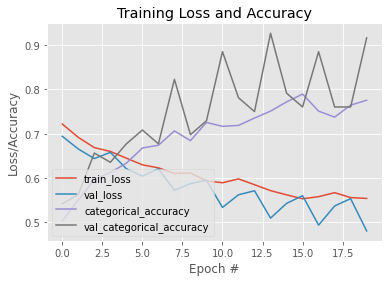

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), hist["categorical_accuracy"], label="categorical_accuracy")
plt.plot(np.arange(0, N), hist["val_categorical_accuracy"], label="val_categorical_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
pred=model.predict(
    x = generator(test, testY, 1),
    steps = len(test),
    verbose = 1
)
test_preds = np.argmax(pred, axis=1)
test_trues = np.argmax(testY, axis=-1)
print('Confusion matrix:\n', confusion_matrix(test_trues, test_preds))
print('F1 score:\n', classification_report(test_trues, test_preds))

383/383 [==============================] - 380s 992ms/step
Confusion matrix:
 [[178  14]
 [ 16 175]]
F1 score:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92       192
           1       0.93      0.92      0.92       191

    accuracy                           0.92       383
   macro avg       0.92      0.92      0.92       383
weighted avg       0.92      0.92      0.92       383



In [ ]:
model.save('/content/drive/Shareddrives/UD1/Study/Image Processing/output-v2')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/UD1/Study/Image Processing/output-v2/assets


In [ ]:
model.trainable = True
model.summary()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=100000,
    decay_rate=0.94,
    staircase=True,
)
model.compile(
    optimizer=keras.optimizers.Adam(lr_schedule),  # Very low learning rate
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               163968    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 258       
Total params: 2,422,210
Trainable params: 2,388,098
Non-trainable params: 34,112
______________________________________

In [ ]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
FINE_TUNE_EPOCHS = 10
hist = model.fit(
    x=generator(train, trainY, BATCH_SIZE, shift=False, flip=True, channel=False, zoom=False, brightness=False, rotation=True),
    epochs=FINE_TUNE_EPOCHS,
    steps_per_epoch=len(train)//BATCH_SIZE,
    class_weight= calculated_weights,
    validation_data=generator(val, valY, BATCH_SIZE),
    validation_steps=len(val)//BATCH_SIZE,
    ).history

Epoch 1/10
95/95 [==============================] - 2103s 22s/step - loss: 0.4046 - categorical_accuracy: 0.9061 - val_loss: 0.3678 - val_categorical_accuracy: 0.9489
Epoch 2/10
95/95 [==============================] - 99s 1s/step - loss: 0.3661 - categorical_accuracy: 0.9461 - val_loss: 0.3877 - val_categorical_accuracy: 0.9205
Epoch 3/10
95/95 [==============================] - 99s 1s/step - loss: 0.3526 - categorical_accuracy: 0.9593 - val_loss: 0.3335 - val_categorical_accuracy: 0.9858
Epoch 4/10
95/95 [==============================] - 100s 1s/step - loss: 0.3426 - categorical_accuracy: 0.9713 - val_loss: 0.3308 - val_categorical_accuracy: 0.9830
Epoch 5/10
95/95 [==============================] - 100s 1s/step - loss: 0.3321 - categorical_accuracy: 0.9815 - val_loss: 0.3411 - val_categorical_accuracy: 0.9744
Epoch 6/10
95/95 [==============================] - 101s 1s/step - loss: 0.3299 - categorical_accuracy: 0.9842 - val_loss: 0.3265 - val_categorical_accuracy: 0.9858
Epoch 7/10

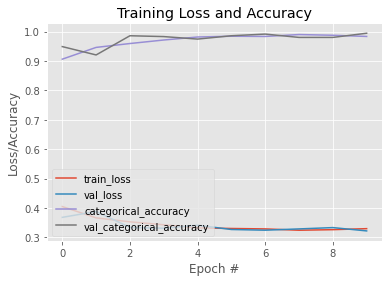

In [ ]:
N = FINE_TUNE_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), hist["categorical_accuracy"], label="categorical_accuracy")
plt.plot(np.arange(0, N), hist["val_categorical_accuracy"], label="val_categorical_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
pred =model.predict(
    x = generator(test, testY, 1),
    steps = len(test),
    verbose = 1
)
test_preds = np.argmax(pred, axis=1)
test_trues = np.argmax(testY, axis=-1)
print('Confusion matrix:\n', confusion_matrix(test_trues, test_preds))
print('F1 score:\n', classification_report(test_trues, test_preds))

383/383 [==============================] - 8s 22ms/step
Confusion matrix:
 [[191   1]
 [  6 185]]
F1 score:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       192
           1       0.99      0.97      0.98       191

    accuracy                           0.98       383
   macro avg       0.98      0.98      0.98       383
weighted avg       0.98      0.98      0.98       383



In [ ]:
model.save('/content/drive/Shareddrives/UD1/Study/Image Processing/output_finetuned-v2')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/UD1/Study/Image Processing/output_finetuned-v2/assets


# Test with local image

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/UD1/Study/Image Processing/output-v2')

In [ ]:
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               163968    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 258       
Total params: 2,422,210
Trainable params: 2,388,098
Non-trainable params: 34,112
______________________________________

In [ ]:
test_img = cv2.imread('/content/photo.jpg')
test_img = cv2.resize(test_img, (224, 224))
test_result = model.predict(x = np.array([test_img]), steps=1, verbose=1)
print(test_result)
np.argmax(test_result, axis=1)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))